# Development of CT/MRI data modility 

## Setup and DATA DOWNLOADING 


In [82]:
pwd

'/workspace/Diploma_Project/Data_TCGA'

In [9]:
# First, install the tcia_utils package
!pip install --upgrade --break-system-packages -q tcia-utils

import pandas as pd
from tcia_utils import nbia
import logging
import os

# Set up logging (especially for Colab)
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(message)s', level=logging.INFO)


In [28]:
def download_ct_mr_data(collection, output_path="tciaDownload", num_series=None):
    logging.info(f"Processing collection: {collection}")

    # 1. Query all CT and MR series in the collection
    series_df = nbia.getSeries(collection=collection, format="df")
    series_df = series_df[series_df["Modality"].isin(["CT", "MR"])]

    if series_df.empty:
        logging.warning(f"No CT or MR series found in {collection}")
        return

    # 2. Save metadata
    os.makedirs(f"{output_path}/{collection}", exist_ok=True)
    metadata_path = f"{output_path}/{collection}/series_metadata.csv"
    series_df.to_csv(metadata_path, index=False)
    logging.info(f"Saved metadata to {metadata_path}")

    # 3. Download series
    logging.info(f"Starting download of {'all' if num_series is None else num_series} series...")

    if num_series is not None:
        nbia.downloadSeries(series_df, input_type="df", path=f"{output_path}/{collection}", number=num_series)
    else:
        nbia.downloadSeries(series_df, input_type="df", path=f"{output_path}/{collection}")

    logging.info(f"Download completed for collection: {collection}")


In [29]:
pwd

'/workspace/Diploma_Project/Data_TCGA'

In [30]:
# Download full CT/MR dataset (remove `number=...` to get all)
collections = ["TCGA-KIRC", "CPTAC-CCRCC"]

for col in collections:
    download_ct_mr_data(col, num_series=None)  # Set to an integer for testing if needed


2025-03-25 15:06:40,690 - INFO - Processing collection: TCGA-KIRC
2025-03-25 15:06:40,691 - INFO - Calling getSeries with parameters {'Collection': 'TCGA-KIRC'}
2025-03-25 15:06:44,358 - INFO - Saved metadata to tciaDownload/TCGA-KIRC/series_metadata.csv
2025-03-25 15:06:44,358 - INFO - Starting download of all series...
2025-03-25 15:06:44,359 - INFO - Downloading 2650 out of 2650 Series Instance UIDs (scans).
2025-03-25 15:06:44,359 - INFO - Directory 'tciaDownload/TCGA-KIRC' already exists.
2025-03-25 15:06:44,360 - INFO - Downloading... https://services.cancerimagingarchive.net/nbia-api/services/v2/getImage?NewFileNames=Yes&SeriesInstanceUID=1.3.6.1.4.1.14519.5.2.1.9203.4004.652695091345533290618011349477
2025-03-25 15:06:46,221 - INFO - Downloading... https://services.cancerimagingarchive.net/nbia-api/services/v2/getImage?NewFileNames=Yes&SeriesInstanceUID=1.3.6.1.4.1.14519.5.2.1.9203.4004.291572847801649876319627160956
2025-03-25 15:06:48,579 - INFO - Downloading... https://servi

## Verification Script for downlaod dataset 

In [32]:
import pandas as pd
from pathlib import Path

def verify_download(dataset_path: str, metadata_filename: str):
    dataset_path = Path(dataset_path)
    metadata_path = dataset_path / metadata_filename

    print(f"\n🔍 Verifying downloads for: {dataset_path.name}")

    # Load metadata
    metadata = pd.read_csv(metadata_path)

    # SeriesInstanceUIDs from metadata
    expected_series = set(metadata["SeriesInstanceUID"].astype(str))

    # Folders in the dataset path (assuming 1 folder per SeriesInstanceUID)
    existing_series = set([p.name for p in dataset_path.iterdir() if p.is_dir()])

    # Compare
    missing_series = expected_series - existing_series
    extra_series = existing_series - expected_series

    print(f"📦 Total expected: {len(expected_series)}")
    print(f"✅ Found: {len(existing_series)}")
    print(f"❌ Missing: {len(missing_series)}")
    print(f"🆓 Extra (unexpected): {len(extra_series)}")

    if missing_series:
        print(f"  Missing UIDs (sample): {list(missing_series)[:5]}")
    if extra_series:
        print(f"  Extra UIDs (sample): {list(extra_series)[:5]}")
    
    return missing_series, extra_series


# Check both datasets
verify_download("/workspace/Diploma_Project/Data_TCGA/tciaDownload/CPTAC-CCRCC", "series_metadata.csv")
verify_download("/workspace/Diploma_Project/Data_TCGA/tciaDownload/TCGA-KIRC", "series_metadata.csv")



🔍 Verifying downloads for: CPTAC-CCRCC
📦 Total expected: 814
✅ Found: 815
❌ Missing: 0
🆓 Extra (unexpected): 1
  Extra UIDs (sample): ['.ipynb_checkpoints']

🔍 Verifying downloads for: TCGA-KIRC
📦 Total expected: 2650
✅ Found: 2651
❌ Missing: 0
🆓 Extra (unexpected): 1
  Extra UIDs (sample): ['.ipynb_checkpoints']


(set(), {'.ipynb_checkpoints'})

## Here we start analysis after downloaded the dataset 

## ✅ Step 1: Analyze Metadata CSVs

The paper mentions filtering based on:

1. **Modality type**: Keep only **CT** and **MRI** (i.e., **MR**).
2. **Series description**:
   - Remove **localizer**, **pre-contrast**, and scans **far from diagnosis**.
3. **View**: Keep **axial view** only.
4. **Scan date relevance**: Prefer scans **close to the diagnosis date**.


### 🔍 What to Do Now

Let’s load and explore both CSV files to see what columns are available for filtering (e.g., `Modality`, `SeriesDescription`, `SeriesDate`, `BodyPartExamined`, etc.).

Please run this code in your notebook or terminal and share the output:


In [23]:
import pandas as pd

# Load metadata
cptac_df = pd.read_csv('/workspace/Diploma_Project/Data_TCGA/tciaDownload/CPTAC-CCRCC/series_metadata.csv')
tcga_df = pd.read_csv('/workspace/Diploma_Project/Data_TCGA/tciaDownload/TCGA-KIRC/series_metadata.csv')

# Preview structure
print("CPTAC columns:", cptac_df.columns.tolist())
print("TCGA columns:", tcga_df.columns.tolist())

# Preview unique modalities
print("CPTAC Modalities:", cptac_df['Modality'].unique())
print("TCGA Modalities:", tcga_df['Modality'].unique())

# Preview unique SeriesDescriptions
print("CPTAC Series Descriptions:", cptac_df['SeriesDescription'].dropna().unique()[:10])
print("TCGA Series Descriptions:", tcga_df['SeriesDescription'].dropna().unique()[:10])


CPTAC columns: ['SeriesInstanceUID', 'StudyInstanceUID', 'Modality', 'ProtocolName', 'SeriesDate', 'SeriesDescription', 'BodyPartExamined', 'SeriesNumber', 'Collection', 'PatientID', 'Manufacturer', 'ManufacturerModelName', 'SoftwareVersions', 'ImageCount', 'TimeStamp', 'LicenseName', 'LicenseURI', 'CollectionURI', 'FileSize', 'DateReleased', 'StudyDesc', 'StudyDate', 'ThirdPartyAnalysis']
TCGA columns: ['SeriesInstanceUID', 'StudyInstanceUID', 'Modality', 'SeriesDate', 'SeriesDescription', 'BodyPartExamined', 'SeriesNumber', 'Collection', 'PatientID', 'Manufacturer', 'ManufacturerModelName', 'SoftwareVersions', 'ImageCount', 'TimeStamp', 'LicenseName', 'LicenseURI', 'CollectionURI', 'FileSize', 'DateReleased', 'StudyDesc', 'StudyDate', 'ProtocolName']
CPTAC Modalities: ['CT' 'MR']
TCGA Modalities: ['MR' 'CT']
CPTAC Series Descriptions: ['FAZA ZYLNA  5.0  SPO  cor  cor' 'OPOZNIONA  5.0  B30f'
 'J.BRZUSZNA  5.0  B30f' 'FAZA TETNICZA 3D' 'J.BRZUSZNA  5.0 3D'
 'OPOZNIONA  5.0  SPO  cor  c

In [25]:
import pandas as pd

# Load metadata
cptac_df = pd.read_csv('/workspace/Diploma_Project/Data_TCGA/tciaDownload/CPTAC-CCRCC/series_metadata.csv')
tcga_df = pd.read_csv('/workspace/Diploma_Project/Data_TCGA/tciaDownload/TCGA-KIRC/series_metadata.csv')

# Convert descriptions to strings and drop NaN values
cptac_descriptions = set(cptac_df['SeriesDescription'].astype(str).replace('nan', pd.NA).dropna().unique())
tcga_descriptions = set(tcga_df['SeriesDescription'].astype(str).replace('nan', pd.NA).dropna().unique())

# Find descriptions unique to CPTAC, unique to TCGA, and common in both
only_cptac = cptac_descriptions - tcga_descriptions
only_tcga = tcga_descriptions - cptac_descriptions
common = cptac_descriptions & tcga_descriptions

# Print results
def print_descriptions(descriptions, title):
    print(f"\n{title} ({len(descriptions)}):")
    print("-" * (len(title) + 10))
    for i, desc in enumerate(sorted(descriptions, key=lambda x: str(x).lower()), 1):  # Case-insensitive sort
        print(f"{i}. {desc}")

# Print unique to CPTAC
print_descriptions(only_cptac, "Unique to CPTAC-CCRCC")

# Print unique to TCGA
print_descriptions(only_tcga, "Unique to TCGA-KIRC")

# Print common descriptions
print_descriptions(common, "Common in both datasets")


Unique to CPTAC-CCRCC (490):
-------------------------------
1. + SC
2. +C 10 MIN
3. 0.625
4. 0.625 +C
5. 0.625s Axial  soft  (DR 30%)
6. 140SEC DELAY DIAPHRAGM TO CREST
7. 2 x 2 sag
8. 2.0
9. 2.5
10. 2.5 +C
11. 2.5 SOFT
12. 2.5 standard
13. 2.5 X2.5 NONCON
14. 2.5mm
15. 2.5MM ADRENAL
16. 2.5mm Axials
17. 2.5s soft
18. 2D Coronal MIPs
19. 2D_
20. 2D_TIMING
21. 2X2 COR
22. 2x2 coronal avg
23. 2X2 SAG
24. 2x2 sagital avg
25. 3 min ABD  3.0  B31f
26. 3 min ABD  3.0  B40f
27. 3.75 i+
28. 3.75 i-
29. 3.75mm Standard
30. 3D_
31. 3D__MIP_COR
32. 3D_MRCP
33. 3Plane Loc SSFSE
34. 4.0
35. 5 X 5 ABDOMEN/PELVIS
36. 5.0 SOFT
37. 5mm
38. 5MM---150SEC POST INJ. DELAY
39. 5S AXIAL SOFT
40. 80/60
41. 90 sec ABD  3.0  B31f
42. <MPR Range[3]>
43. <MPR Thick Range[1]>
44. <MPR Thick Range[2]>
45. <MPR Thick Range[3]>
46. _SS_Cor
47. _SS_TE 140
48. _SS_TE 80
49. A/P 3.0  B31f PRE
50. A/P 3.0  B70f
51. A/P WITH 5.0 STND
52. ABD   3.0  B31f
53. ABD   3.0  SPO  cor
54. ABD   3.0  SPO  sag
55. ABD  3.0  B31f


## ✅ Step 2: Filter Relevant Scans

### 2.1. Keep only CT and MR  
We already saw that both modalities are available. Let’s keep only those rows.

### 2.2. Remove Unwanted Scans  
We want to exclude:

- **Localizers**
- **Pre-contrast or non-contrast**
- **Monitoring**
- **Coronal/Sagittal views**
- **Scans with suspicious or unclear `SeriesDescriptions`**

We’ll also keep only **axial scans**.


## 🔎 Filter Logic (based on SeriesDescription)
Let’s define exclusion/inclusion rules. The logic may look like this:

In [58]:
# Enhanced patterns for exclusion (same as before)
EXCLUDE_KEYWORDS = [
    'localizer', 'monitoring', 'pre-contrast', 'non-contrast', 'noncontrast',
    'coronal', 'sagittal', 'scout', 'survey', 'locator', 'topogram',
    'unenhanced', 'precontrast', 'pre contrast', 'without contrast'
]

# More specific patterns for inclusion (now includes MR/CT-specific terms)
INCLUDE_KEYWORDS = [
    'axial', 'ax', 
    'arterial', 'venous', 'delay', 'delayed', 'nephrographic', 'corticomedullary',
    'ax t1', 'ax t2', 'axial t1', 'axial t2', 'ax flair',
    'post contrast', 'post-contrast', 'with contrast', '+c', 'contrast'
]

# Additional MR-specific sequences to include (will help filter MRI better)
MR_INCLUDE = [
    'dwi', 'adc', 'dynamic', 'vibe', 'lava', 'fame', 'flash', 'fspgr'
]

# CT-specific phases to include (will help filter CT better)
CT_INCLUDE = [
    'portal', 'parenchymal', 'excretory', 'urogram', 'nephro', 'cortical'
]

Let me write the filtering code you can run on both datasets, then we’ll inspect how many valid scans remain per patient.

## 🧠 Filtering Code

In [27]:
import re

def filter_scans(df, modality=None):
    """
    Enhanced filtering function with proper regex escaping
    """
    # Create clean description
    df['SeriesDescription_clean'] = df['SeriesDescription'].fillna('').str.lower()
    
    # Optional: filter by modality
    if modality:
        df = df[df['Modality'] == modality]
    
    # Escape all special regex characters in exclude patterns
    exclude_patterns = [re.escape(pattern) for pattern in EXCLUDE_KEYWORDS]
    exclude = df['SeriesDescription_clean'].str.contains(
        '|'.join(exclude_patterns), case=False, na=False, regex=True
    )
    df = df[~exclude]
    
    # Modality-specific inclusion patterns
    include_criteria = INCLUDE_KEYWORDS.copy()
    
    if modality == 'MR':
        include_criteria.extend(MR_INCLUDE)
    elif modality == 'CT':
        include_criteria.extend(CT_INCLUDE)
    
    # Escape all special regex characters in include patterns
    include_patterns = [re.escape(pattern) for pattern in include_criteria]
    include = df['SeriesDescription_clean'].str.contains(
        '|'.join(include_patterns), case=False, na=False, regex=True
    )
    df = df[include]
    
    return df

## ✅ Summary So Far

- **Filtered CT/MRI scans**:
  - **CPTAC**: 191 scans  
  - **TCGA**: 716 scans

- We see patients with **multiple** scans (26–36 per patient in some cases).

- This matches what the **MMIST-ccRCC** paper describes: multiple scans per patient, which will be handled using **MIL-based selection** later.


## Step 3: Organize Scans for Per-Patient MIL

We now need to organize scans into a structure that’s easy to work with for:

- **Preprocessing** (resizing, normalization)
- **Feature extraction** (MeD3D)
- **MIL-based selection per patient**


### 🛠️ Let's Export Filtered Metadata per Patient

This will help us:

- **Organize** file system  
- **Track** `SeriesInstanceUID`s for each patient  
- **Keep** modality info (CT/MR)

Here’s the code to save per-patient filtered scan info:


In [28]:
# Apply filtering with the fixed function
filtered_cptac = filter_scans(cptac_df)
filtered_tcga = filter_scans(tcga_df)

# Save filtered metadata for further processing
filtered_cptac.to_csv('/workspace/Diploma_Project/Data_TCGA/filtered_metadata_cptac.csv', index=False)
filtered_tcga.to_csv('/workspace/Diploma_Project/Data_TCGA/filtered_metadata_tcga.csv', index=False)

# Check remaining scans
print("Remaining CPTAC CT/MRI scans:", filtered_cptac.shape[0])
print("Remaining TCGA CT/MRI scans:", filtered_tcga.shape[0])

# Count scans per patient
print(filtered_cptac['PatientID'].value_counts().head())
print(filtered_tcga['PatientID'].value_counts().head())

Remaining CPTAC CT/MRI scans: 179
Remaining TCGA CT/MRI scans: 740
PatientID
C3L-00610    29
C3N-02262    13
C3N-01803    13
C3L-01463    10
C3N-02439    10
Name: count, dtype: int64
PatientID
TCGA-CW-5585    23
TCGA-CW-6090    17
TCGA-B8-5550    16
TCGA-B8-5158    16
TCGA-BP-5010    14
Name: count, dtype: int64


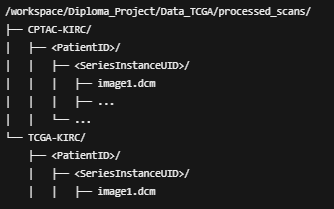

We can now generate a list of relevant SeriesInstanceUIDs per patient, which you’ll then match with downloaded DICOM files.

## ✅ Step 4: Reorganize Scans by PatientID

We’ll use the filtered metadata to:

- **Map** each `SeriesInstanceUID` to its `PatientID`
- **Move** folders named after `SeriesInstanceUID` into their respective `PatientID` directories


🛠️ Code to Reorganize Structure

In [31]:
from pathlib import Path
import shutil
import pydicom

# Same collection mapping as before
collection_mapping = {
    "CPTAC-KIRC": "CPTAC-CCRCC",
    "TCGA-KIRC": "TCGA-KIRC"
}

# Same paths as before
base_dir = Path("/workspace/Diploma_Project/Data_TCGA/tciaDownload")
out_dir = Path("/workspace/Diploma_Project/Data_TCGA/processed_scans/organized_scans")
out_dir.mkdir(parents=True, exist_ok=True)

# Load metadata (same as before)
filtered_cptac = pd.read_csv('/workspace/Diploma_Project/Data_TCGA/filtered_metadata_cptac.csv')
filtered_tcga = pd.read_csv('/workspace/Diploma_Project/Data_TCGA/filtered_metadata_tcga.csv')

# Combine and map collections (same as before)
filtered_cptac['collection'] = 'CPTAC-KIRC'
filtered_tcga['collection'] = 'TCGA-KIRC'
metadata_df = pd.concat([filtered_cptac, filtered_tcga])
series_to_patient = metadata_df.set_index('SeriesInstanceUID')[['PatientID', 'collection']].to_dict(orient='index')

# Process both collections (same logic as before)
for logical_name, real_folder_name in collection_mapping.items():
    src_root = base_dir / real_folder_name
    for folder in src_root.iterdir():
        if not folder.is_dir():
            continue

        dicom_files = list(folder.glob("*.dcm"))
        if not dicom_files:
            continue

        try:
            dcm = pydicom.dcmread(str(dicom_files[0]), stop_before_pixels=True)
            series_uid = dcm.SeriesInstanceUID
        except Exception as e:
            print(f"[!] Failed to read DICOM in {folder.name}: {e}")
            continue

        if series_uid not in series_to_patient:
            continue

        patient_id = series_to_patient[series_uid]['PatientID']
        logical_collection = series_to_patient[series_uid]['collection']

        # Same destination structure: collection/patient_id/series_uid
        dst = out_dir / logical_collection / patient_id / series_uid
        dst.mkdir(parents=True, exist_ok=True)

        for file in dicom_files:
            shutil.copy(file, dst / file.name)

        print(f"[✓] Copied {series_uid} to {dst}")

[✓] Copied 1.3.6.1.4.1.14519.5.2.1.6450.2626.286348599463095473978607242373 to /workspace/Diploma_Project/Data_TCGA/processed_scans/organized_scans/CPTAC-KIRC/C3L-00817/1.3.6.1.4.1.14519.5.2.1.6450.2626.286348599463095473978607242373
[✓] Copied 1.3.6.1.4.1.14519.5.2.1.6450.2626.407065355337574372105969021088 to /workspace/Diploma_Project/Data_TCGA/processed_scans/organized_scans/CPTAC-KIRC/C3L-00610/1.3.6.1.4.1.14519.5.2.1.6450.2626.407065355337574372105969021088
[✓] Copied 1.3.6.1.4.1.14519.5.2.1.6450.2626.239488360299829278819369071001 to /workspace/Diploma_Project/Data_TCGA/processed_scans/organized_scans/CPTAC-KIRC/C3L-00610/1.3.6.1.4.1.14519.5.2.1.6450.2626.239488360299829278819369071001
[✓] Copied 1.3.6.1.4.1.14519.5.2.1.6450.2626.958170760110524970277869189398 to /workspace/Diploma_Project/Data_TCGA/processed_scans/organized_scans/CPTAC-KIRC/C3L-00610/1.3.6.1.4.1.14519.5.2.1.6450.2626.958170760110524970277869189398
[✓] Copied 1.3.6.1.4.1.14519.5.2.1.7085.2626.4854357472951782554

## Data analysis  what we filter from data 

### Scan Type Analysis (Before vs After Filtering)


===== CPTAC-CCRCC Dataset Analysis =====
Original scans: 814
Filtered scans: 191
Percentage kept: 23.5%


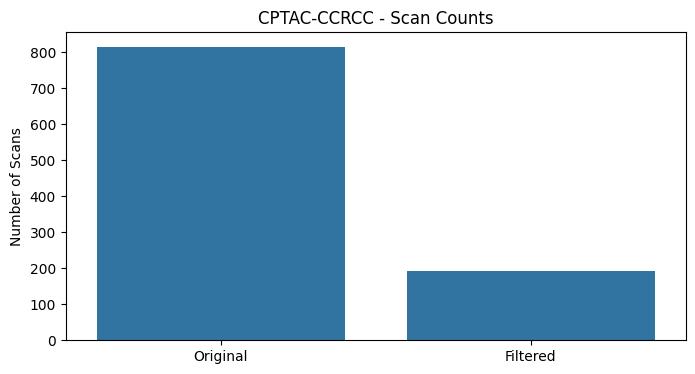


Modality Distribution:
          Original  Filtered
Modality                    
CT             574        54
MR             240       137


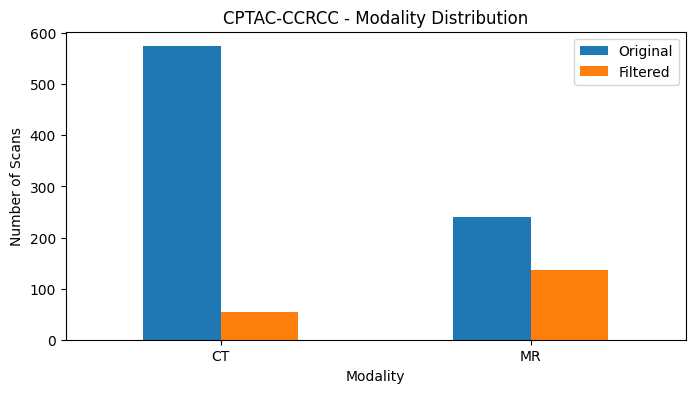


Top 10 Kept Scan Types:
SeriesDescription
Topogram  0.6  T20s             13
Topogram  1.0  T20s              6
Axial Body CE                    4
T1 VIBE FS AX  BH 4 MEASURES     4
Topogram  0.6  T20f              3
AX THK DELAY                     2
AX THN DELAY                     2
AX THK PORTAL                    2
AX THN PORTAL                    2
AX THK NC                        2
Name: count, dtype: int64


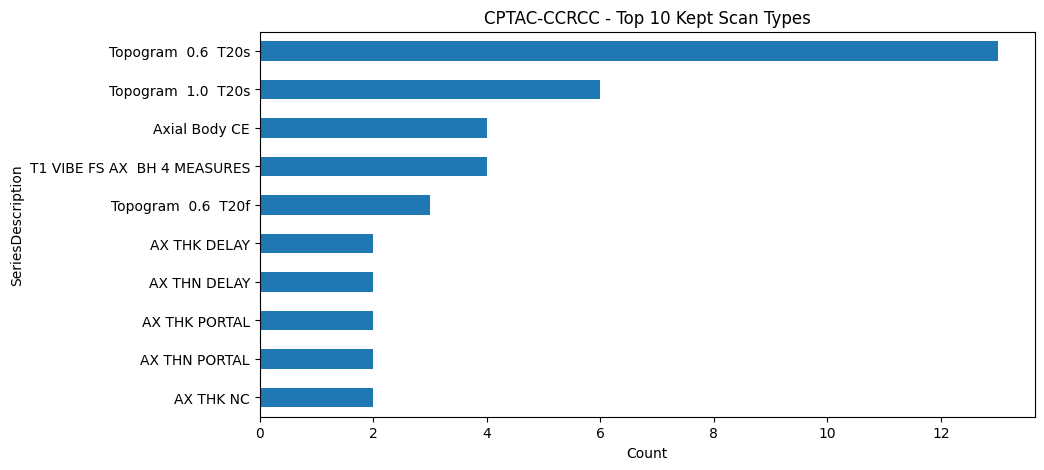


Top 10 Excluded Scan Types:
SeriesDescription
Topogram  0.6  T20s            13
SCOUT                          12
Scout                           8
Faza tetnicza  1.5  3D          7
Jama Brzuszna  1.5  3D          7
Faza zylna  1.5  3D             7
Jama Brzuszna  5.0  miekkie     7
Faza zylna  5.0  miekkie        7
Faza tetnicza  5.0  miekkie     7
Smart Prep Series               6
Name: count, dtype: int64


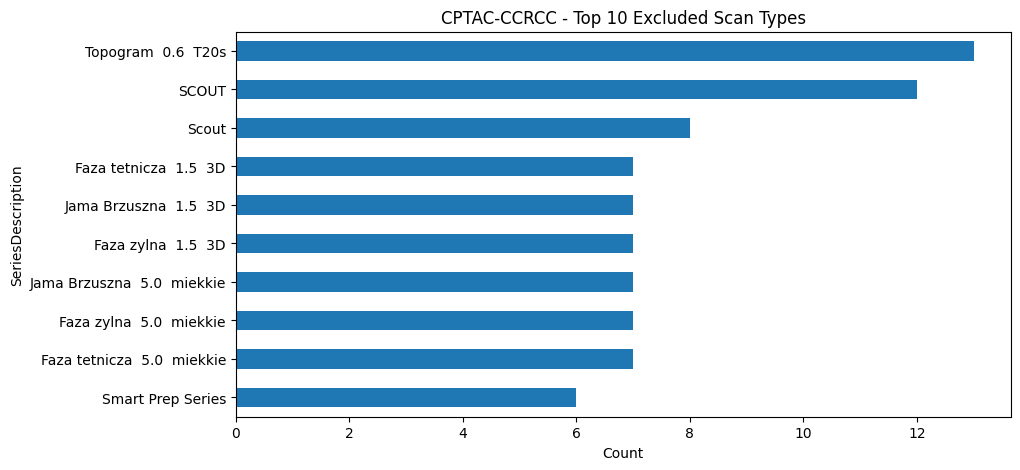


===== TCGA-KIRC Dataset Analysis =====
Original scans: 2650
Filtered scans: 716
Percentage kept: 27.0%


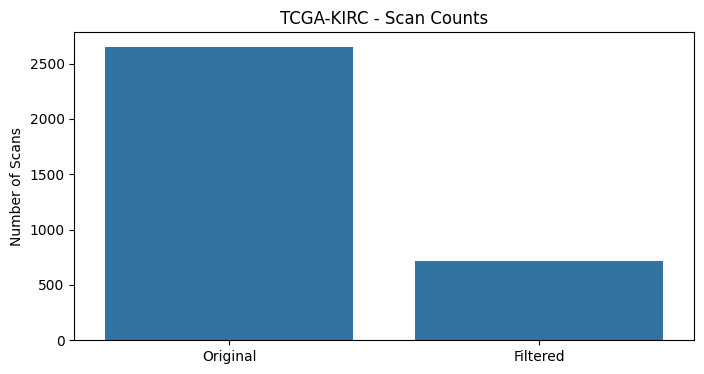


Modality Distribution:
          Original  Filtered
Modality                    
CT            1736       187
MR             914       529


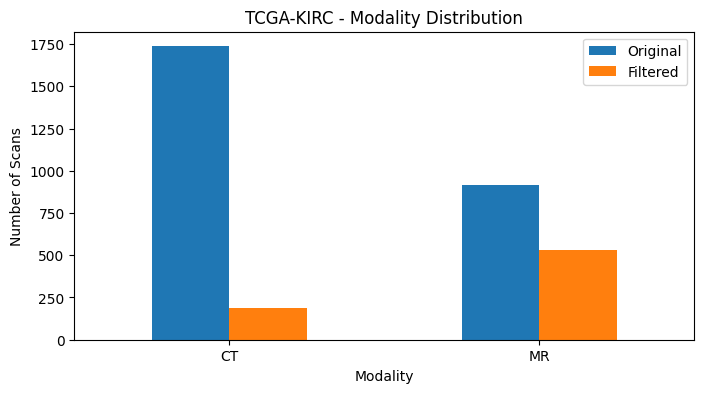


Top 10 Kept Scan Types:
SeriesDescription
Topogram  0.6  T20s         72
Topogram  1.0  T20s         53
AXIAL                       31
Axial T1 post               23
Axial T2                    14
Axial flow sensitive        13
Axial T2 fat sat            12
Axial 3D T1 post fat sat    12
Ax spgr                     12
Axial T1 in/out phase       10
Name: count, dtype: int64


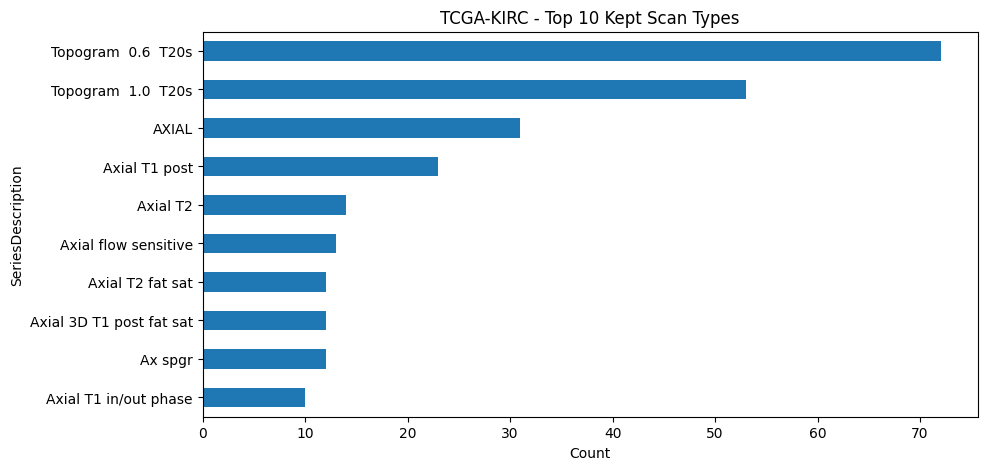


Top 10 Excluded Scan Types:
SeriesDescription
SCOUT                     111
Topogram  0.6  T20s        72
Topogram  1.0  T20s        53
PRE-CONTRAST               43
PRE LIVER                  33
AXIAL                      30
CAP Routine  5.0  B40f     24
CHEST                      20
C/A/P (RENAL)              19
Recon 2: PRE LIVER         16
Name: count, dtype: int64


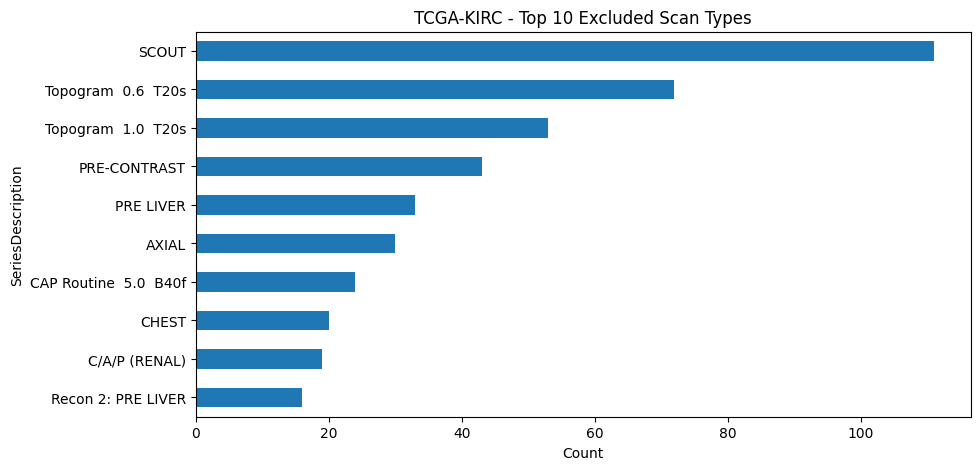

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_filtering(original_df, filtered_df, dataset_name):
    print(f"\n===== {dataset_name} Dataset Analysis =====")
    
    # Basic counts
    original_count = len(original_df)
    filtered_count = len(filtered_df)
    pct_kept = filtered_count/original_count
    
    print(f"Original scans: {original_count}")
    print(f"Filtered scans: {filtered_count}")
    print(f"Percentage kept: {pct_kept:.1%}")
    
    # Plot scan counts
    plt.figure(figsize=(8, 4))
    sns.barplot(x=['Original', 'Filtered'], y=[original_count, filtered_count])
    plt.title(f"{dataset_name} - Scan Counts")
    plt.ylabel("Number of Scans")
    plt.show()
    
    # Modality distribution
    modality_dist = pd.concat([
        original_df['Modality'].value_counts().rename('Original'),
        filtered_df['Modality'].value_counts().rename('Filtered')
    ], axis=1).fillna(0)
    
    print("\nModality Distribution:")
    print(modality_dist)
    
    # Plot modality distribution
    modality_dist.plot(kind='bar', figsize=(8, 4))
    plt.title(f"{dataset_name} - Modality Distribution")
    plt.ylabel("Number of Scans")
    plt.xticks(rotation=0)
    plt.show()
    
    # Top kept scan types
    top_kept = filtered_df['SeriesDescription'].value_counts().head(10)
    print("\nTop 10 Kept Scan Types:")
    print(top_kept)
    
    # Plot top kept scans
    plt.figure(figsize=(10, 5))
    top_kept.plot(kind='barh')
    plt.title(f"{dataset_name} - Top 10 Kept Scan Types")
    plt.xlabel("Count")
    plt.gca().invert_yaxis()
    plt.show()
    
    # Most common excluded scan types
    excluded = original_df[~original_df.index.isin(filtered_df.index)]
    top_excluded = excluded['SeriesDescription'].value_counts().head(10)
    print("\nTop 10 Excluded Scan Types:")
    print(top_excluded)
    
    # Plot excluded scans
    plt.figure(figsize=(10, 5))
    top_excluded.plot(kind='barh')
    plt.title(f"{dataset_name} - Top 10 Excluded Scan Types")
    plt.xlabel("Count")
    plt.gca().invert_yaxis()
    plt.show()
    
    return {
        'original_count': original_count,
        'filtered_count': filtered_count,
        'pct_kept': pct_kept,
        'modality_distribution': filtered_df['Modality'].value_counts().to_dict(),
        'top_kept_scans': top_kept.to_dict(),
        'top_excluded_scans': top_excluded.to_dict()
    }

# Run analysis
cptac_analysis = analyze_filtering(cptac_df, filtered_cptac, "CPTAC-CCRCC")
tcga_analysis = analyze_filtering(tcga_df, filtered_tcga, "TCGA-KIRC")

### Patient-Level Analysis


===== CPTAC-CCRCC Patient-Level Analysis =====
Patients with scans: 35

Scans per patient distribution:
count    35.000000
mean      5.457143
std       6.089252
min       1.000000
25%       1.000000
50%       2.000000
75%       8.000000
max      26.000000
Name: count, dtype: float64


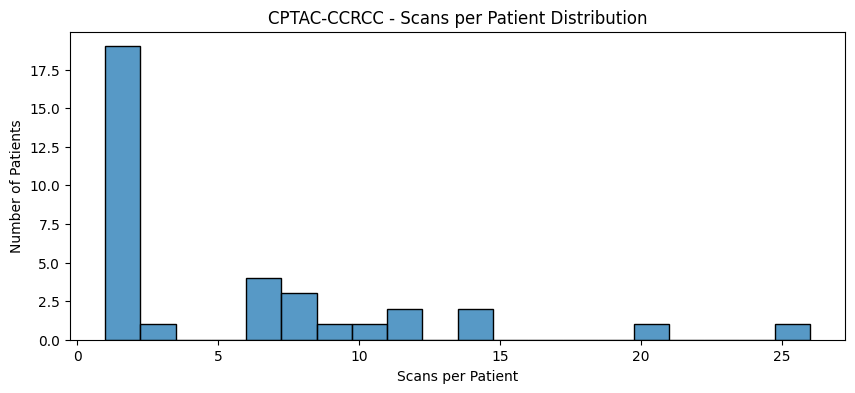


Modality combinations per patient:
Modality
CT       22
MR        7
CT+MR     6
Name: count, dtype: int64


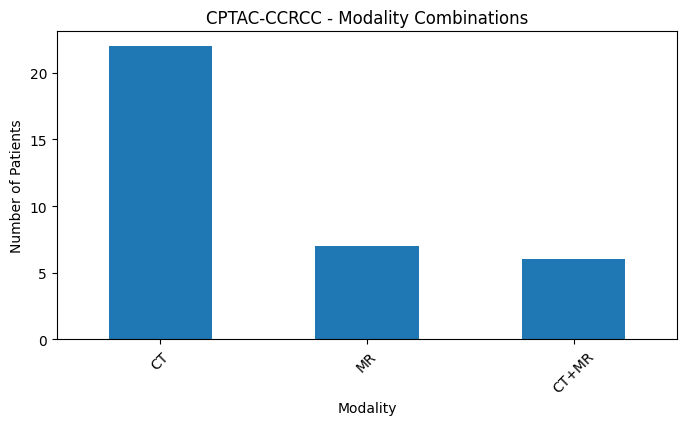


===== TCGA-KIRC Patient-Level Analysis =====
Patients with scans: 100

Scans per patient distribution:
count    100.000000
mean       7.160000
std        6.567013
min        1.000000
25%        2.000000
50%        6.000000
75%        9.000000
max       36.000000
Name: count, dtype: float64


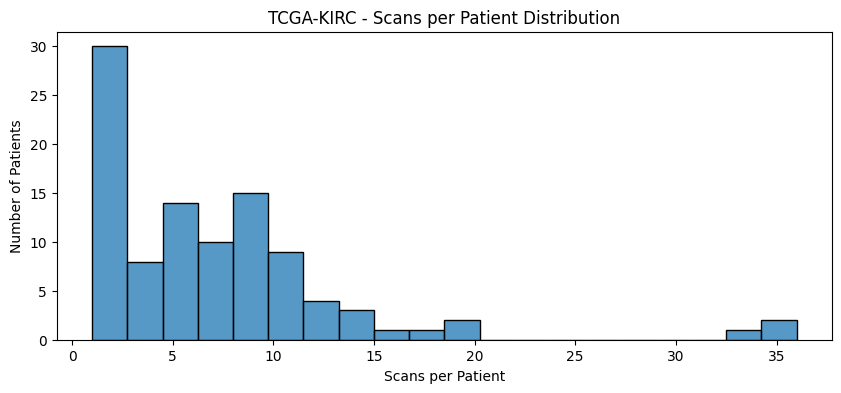


Modality combinations per patient:
Modality
MR       45
CT       38
CT+MR    17
Name: count, dtype: int64


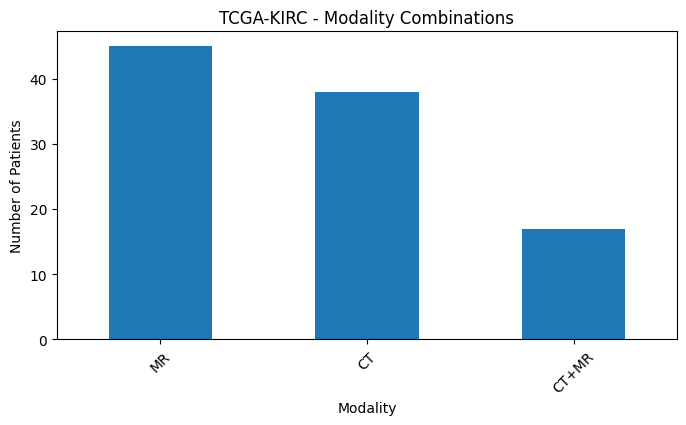

In [78]:
def patient_level_analysis(filtered_df, dataset_name):
    print(f"\n===== {dataset_name} Patient-Level Analysis =====")
    
    # Patients with scans
    patients = filtered_df['PatientID'].nunique()
    print(f"Patients with scans: {patients}")
    
    # Scans per patient distribution
    scans_per_patient = filtered_df['PatientID'].value_counts()
    print("\nScans per patient distribution:")
    print(scans_per_patient.describe())
    
    # Plot scans per patient distribution
    plt.figure(figsize=(10, 4))
    sns.histplot(scans_per_patient, bins=20)
    plt.title(f"{dataset_name} - Scans per Patient Distribution")
    plt.xlabel("Scans per Patient")
    plt.ylabel("Number of Patients")
    plt.show()
    
    # Modality combinations per patient
    modality_combos = filtered_df.groupby('PatientID')['Modality'].apply(
        lambda x: "+".join(sorted(x.unique())))
    modality_combos_counts = modality_combos.value_counts()
    
    print("\nModality combinations per patient:")
    print(modality_combos_counts)
    
    # Plot modality combinations
    plt.figure(figsize=(8, 4))
    modality_combos_counts.plot(kind='bar')
    plt.title(f"{dataset_name} - Modality Combinations")
    plt.ylabel("Number of Patients")
    plt.xticks(rotation=45)
    plt.show()
    
    return {
        'total_patients': patients,
        'scans_per_patient_stats': scans_per_patient.describe().to_dict(),
        'modality_combinations': modality_combos_counts.to_dict()
    }

cptac_patient_stats = patient_level_analysis(filtered_cptac, "CPTAC-CCRCC")
tcga_patient_stats = patient_level_analysis(filtered_tcga, "TCGA-KIRC")

### Scan Type Breakdown (Visualization)

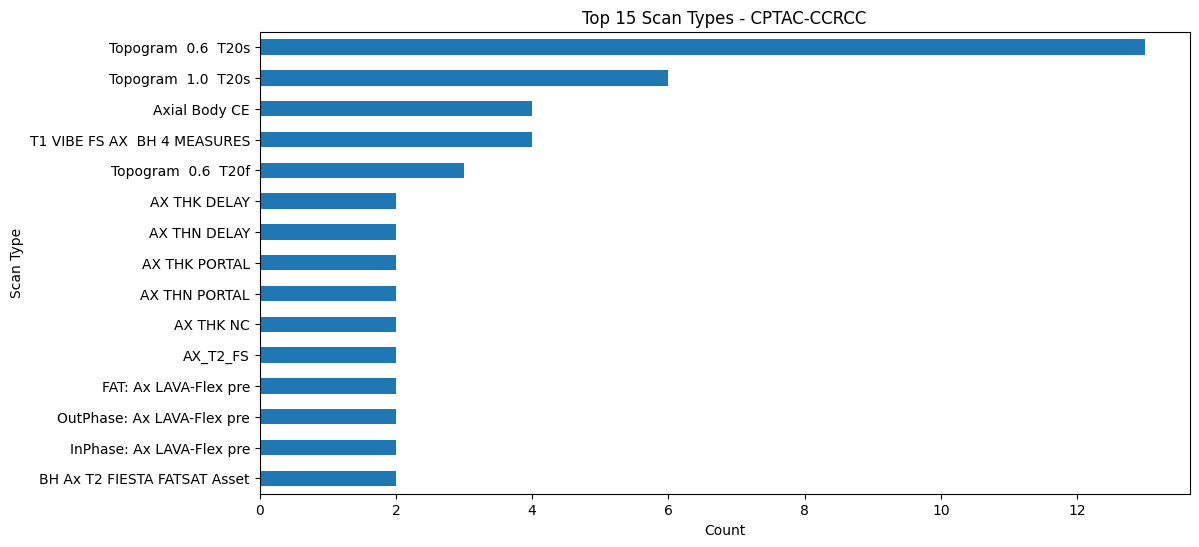

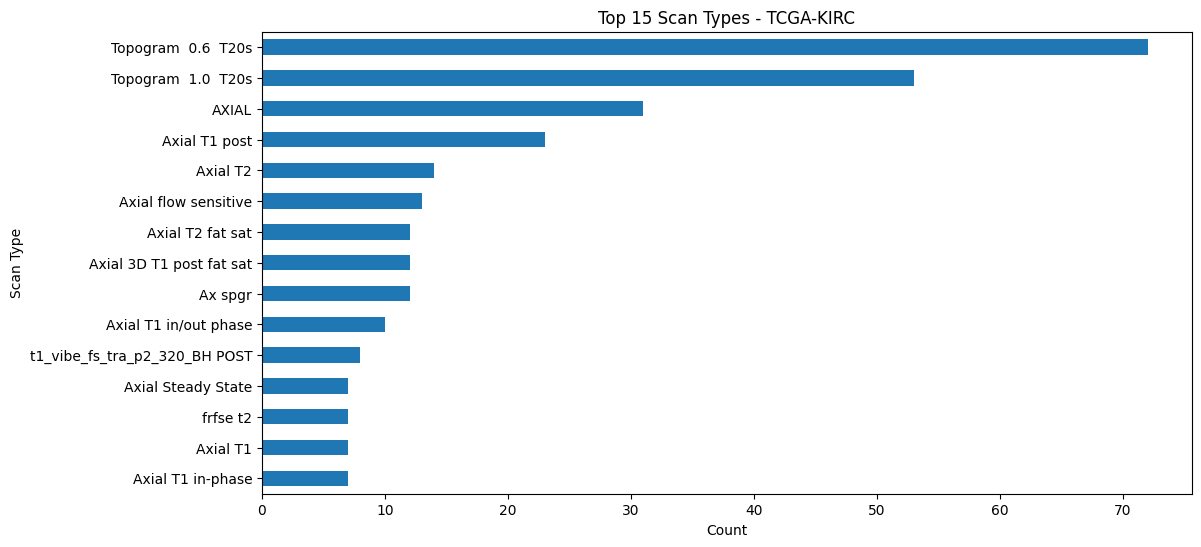

In [79]:
import matplotlib.pyplot as plt

def plot_scan_types(filtered_df, dataset_name, top_n=15):
    # Get top scan types
    top_scans = filtered_df['SeriesDescription'].value_counts().head(top_n)
    
    # Plot
    plt.figure(figsize=(12, 6))
    top_scans.plot(kind='barh')
    plt.title(f"Top {top_n} Scan Types - {dataset_name}")
    plt.xlabel("Count")
    plt.ylabel("Scan Type")
    plt.gca().invert_yaxis()
    plt.show()

plot_scan_types(filtered_cptac, "CPTAC-CCRCC")
plot_scan_types(filtered_tcga, "TCGA-KIRC")

### Modality Comparison

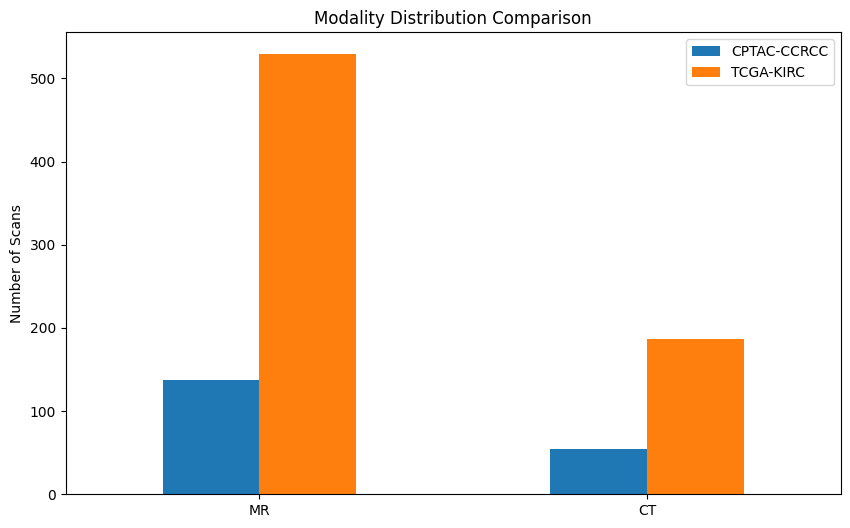

In [80]:
def compare_modalities(cptac_data, tcga_data):
    # Create comparison DataFrame
    comparison = pd.DataFrame({
        'CPTAC-CCRCC': pd.Series(cptac_data['modality_distribution']),
        'TCGA-KIRC': pd.Series(tcga_data['modality_distribution'])
    }).fillna(0)
    
    # Plot
    comparison.plot(kind='bar', figsize=(10, 6))
    plt.title("Modality Distribution Comparison")
    plt.ylabel("Number of Scans")
    plt.xticks(rotation=0)
    plt.show()
    
    return comparison

modality_comparison = compare_modalities(cptac_analysis, tcga_analysis)

### Summary Statistics

=== CPTAC-CCRCC Analysis ===

===== CPTAC-CCRCC Dataset Analysis =====
Original scans: 814
Filtered scans: 191
Percentage kept: 23.5%


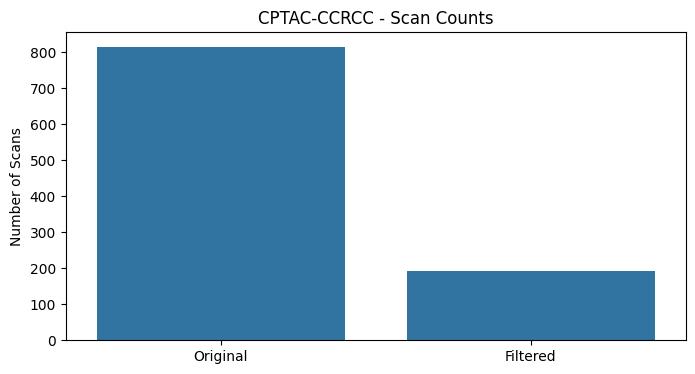


Modality Distribution:
          Original  Filtered
Modality                    
CT             574        54
MR             240       137


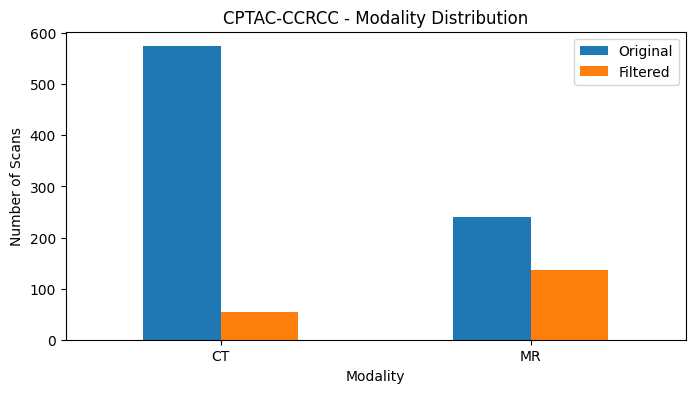


Top 10 Kept Scan Types:
SeriesDescription
Topogram  0.6  T20s             13
Topogram  1.0  T20s              6
Axial Body CE                    4
T1 VIBE FS AX  BH 4 MEASURES     4
Topogram  0.6  T20f              3
AX THK DELAY                     2
AX THN DELAY                     2
AX THK PORTAL                    2
AX THN PORTAL                    2
AX THK NC                        2
Name: count, dtype: int64


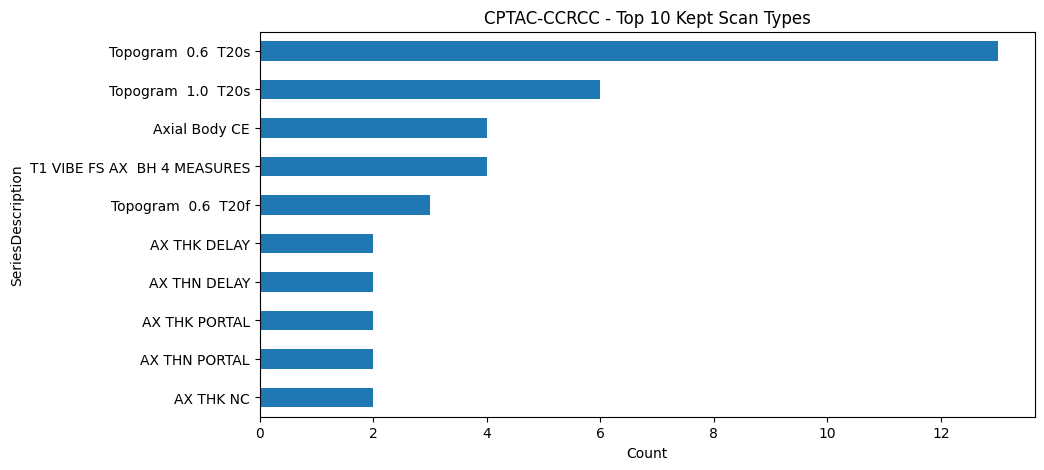


Top 10 Excluded Scan Types:
SeriesDescription
Topogram  0.6  T20s            13
SCOUT                          12
Scout                           8
Faza tetnicza  1.5  3D          7
Jama Brzuszna  1.5  3D          7
Faza zylna  1.5  3D             7
Jama Brzuszna  5.0  miekkie     7
Faza zylna  5.0  miekkie        7
Faza tetnicza  5.0  miekkie     7
Smart Prep Series               6
Name: count, dtype: int64


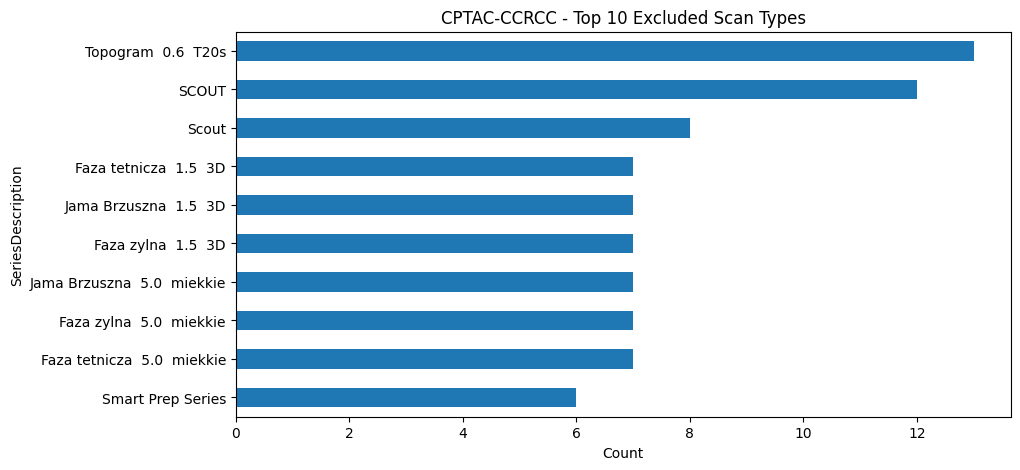


===== CPTAC-CCRCC Patient-Level Analysis =====
Patients with scans: 35

Scans per patient distribution:
count    35.000000
mean      5.457143
std       6.089252
min       1.000000
25%       1.000000
50%       2.000000
75%       8.000000
max      26.000000
Name: count, dtype: float64


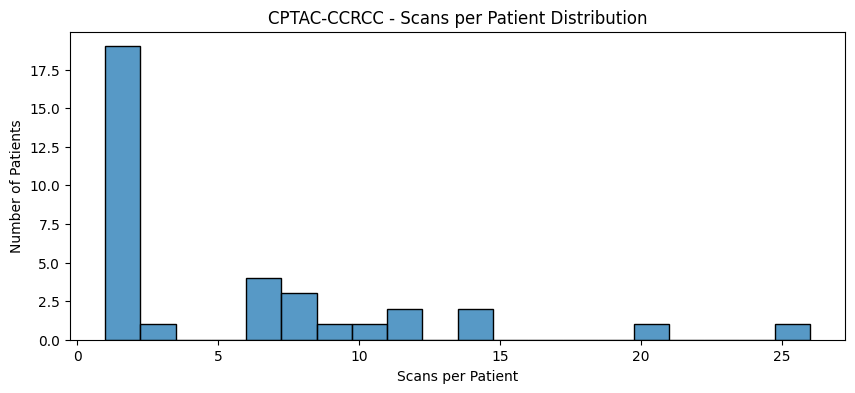


Modality combinations per patient:
Modality
CT       22
MR        7
CT+MR     6
Name: count, dtype: int64


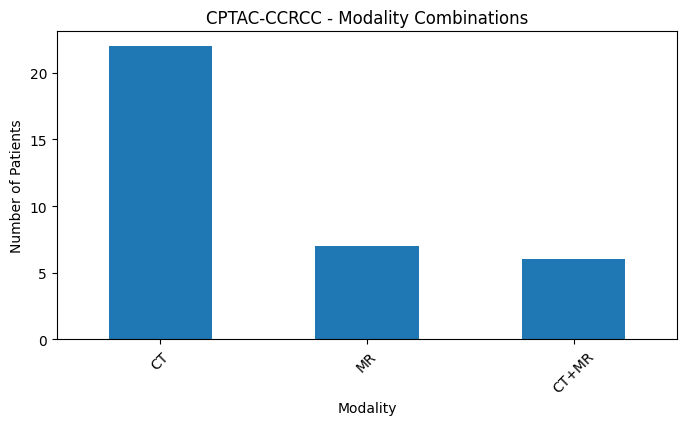


=== TCGA-KIRC Analysis ===

===== TCGA-KIRC Dataset Analysis =====
Original scans: 2650
Filtered scans: 716
Percentage kept: 27.0%


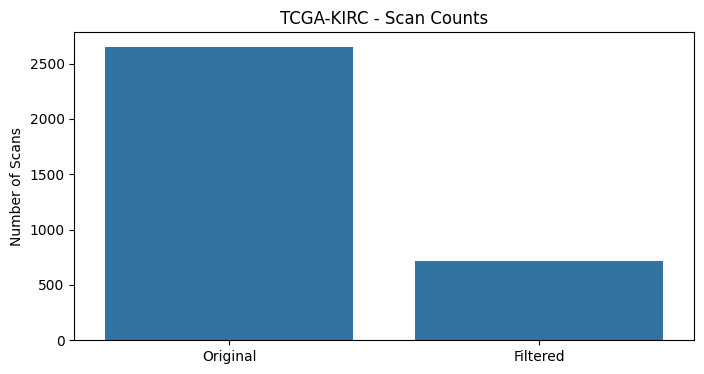


Modality Distribution:
          Original  Filtered
Modality                    
CT            1736       187
MR             914       529


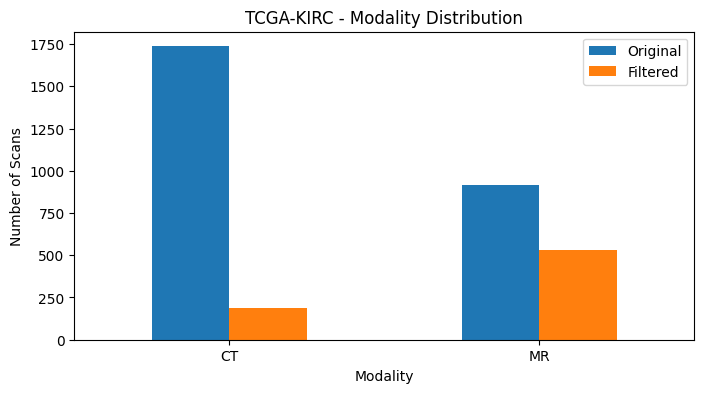


Top 10 Kept Scan Types:
SeriesDescription
Topogram  0.6  T20s         72
Topogram  1.0  T20s         53
AXIAL                       31
Axial T1 post               23
Axial T2                    14
Axial flow sensitive        13
Axial T2 fat sat            12
Axial 3D T1 post fat sat    12
Ax spgr                     12
Axial T1 in/out phase       10
Name: count, dtype: int64


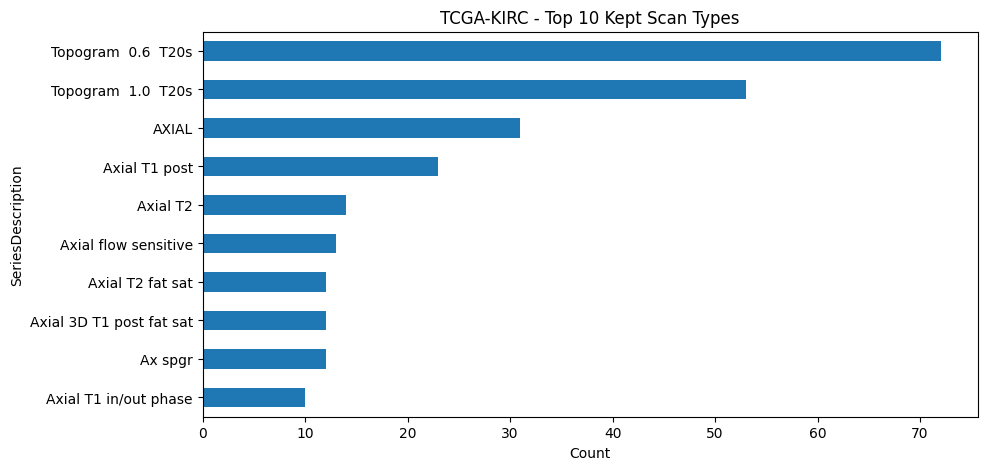


Top 10 Excluded Scan Types:
SeriesDescription
SCOUT                     111
Topogram  0.6  T20s        72
Topogram  1.0  T20s        53
PRE-CONTRAST               43
PRE LIVER                  33
AXIAL                      30
CAP Routine  5.0  B40f     24
CHEST                      20
C/A/P (RENAL)              19
Recon 2: PRE LIVER         16
Name: count, dtype: int64


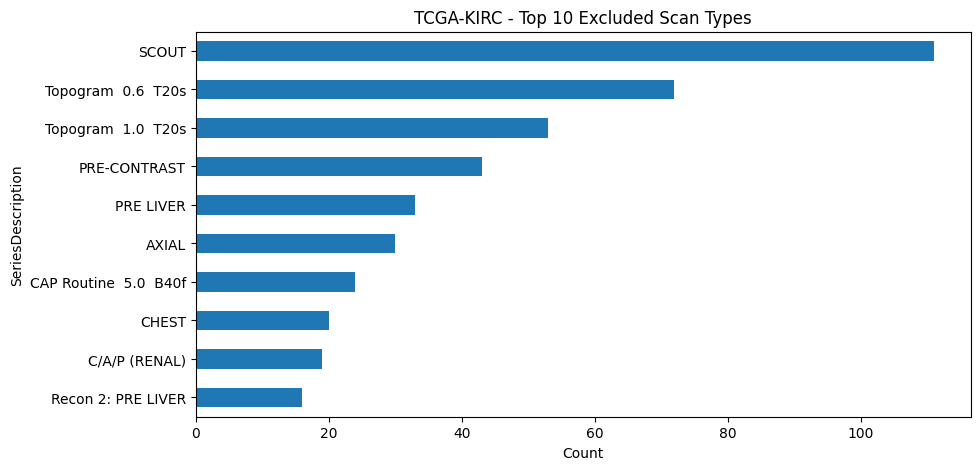


===== TCGA-KIRC Patient-Level Analysis =====
Patients with scans: 100

Scans per patient distribution:
count    100.000000
mean       7.160000
std        6.567013
min        1.000000
25%        2.000000
50%        6.000000
75%        9.000000
max       36.000000
Name: count, dtype: float64


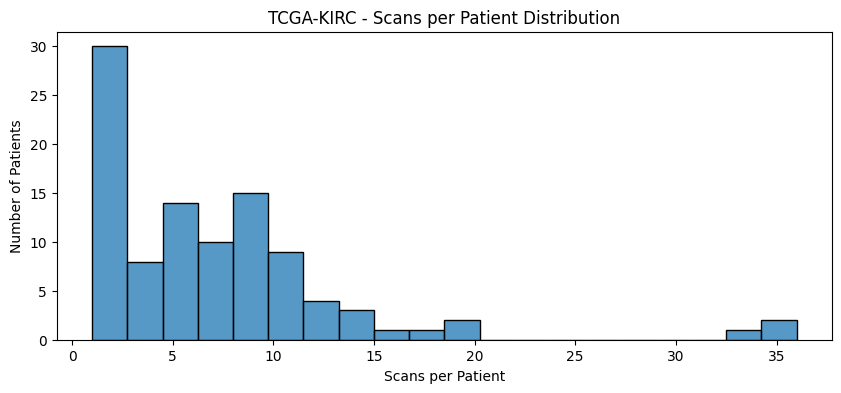


Modality combinations per patient:
Modality
MR       45
CT       38
CT+MR    17
Name: count, dtype: int64


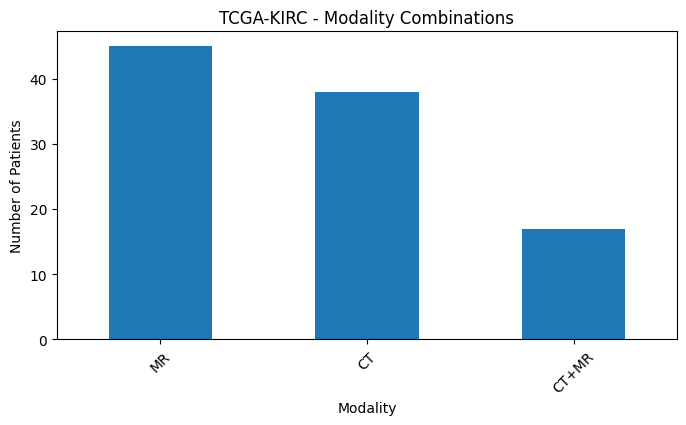


===== Summary Statistics =====
Metric                             CPTAC-CCRCC       TCGA-KIRC
------------------------------------------------------------
Total original scans                       814            2650
Total filtered scans                       191             716
Percentage kept                          23.5%           27.0%
Unique patients                             35             100
Avg scans per patient                      5.5             7.2
CT scans                                    54             187
MRI scans                                  137             529


In [81]:
def print_summary_stats(cptac_analysis, tcga_analysis, cptac_patient_stats=None, tcga_patient_stats=None):
    print("\n===== Summary Statistics =====")
    print(f"{'Metric':<30} {'CPTAC-CCRCC':>15} {'TCGA-KIRC':>15}")
    print("-"*60)
    
    # Safely get values with defaults
    cptac_orig = cptac_analysis.get('original_count', 0)
    tcga_orig = tcga_analysis.get('original_count', 0)
    cptac_filt = cptac_analysis.get('filtered_count', 0)
    tcga_filt = tcga_analysis.get('filtered_count', 0)
    
    # Calculate percentages safely
    cptac_pct = f"{cptac_filt/cptac_orig:.1%}" if cptac_orig else "N/A"
    tcga_pct = f"{tcga_filt/tcga_orig:.1%}" if tcga_orig else "N/A"
    
    # Initialize patient stats with defaults
    cptac_patients = cptac_patient_stats.get('total_patients', 0) if cptac_patient_stats else 0
    tcga_patients = tcga_patient_stats.get('total_patients', 0) if tcga_patient_stats else 0
    
    cptac_avg = cptac_patient_stats.get('scans_per_patient_stats', {}).get('mean', 0) if cptac_patient_stats else 0
    tcga_avg = tcga_patient_stats.get('scans_per_patient_stats', {}).get('mean', 0) if tcga_patient_stats else 0
    
    # Modality counts
    cptac_ct = cptac_analysis.get('modality_distribution', {}).get('CT', 0)
    tcga_ct = tcga_analysis.get('modality_distribution', {}).get('CT', 0)
    cptac_mr = cptac_analysis.get('modality_distribution', {}).get('MR', 0)
    tcga_mr = tcga_analysis.get('modality_distribution', {}).get('MR', 0)
    
    # Print all metrics
    metrics = [
        ('Total original scans', cptac_orig, tcga_orig),
        ('Total filtered scans', cptac_filt, tcga_filt),
        ('Percentage kept', cptac_pct, tcga_pct),
        ('Unique patients', cptac_patients, tcga_patients),
        ('Avg scans per patient', f"{cptac_avg:.1f}", f"{tcga_avg:.1f}"),
        ('CT scans', cptac_ct, tcga_ct),
        ('MRI scans', cptac_mr, tcga_mr)
    ]
    
    for label, cptac_val, tcga_val in metrics:
        print(f"{label:<30} {str(cptac_val):>15} {str(tcga_val):>15}")

# Run analysis
print("=== CPTAC-CCRCC Analysis ===")
cptac_analysis = analyze_filtering(cptac_df, filtered_cptac, "CPTAC-CCRCC")
cptac_patient_stats = patient_level_analysis(filtered_cptac, "CPTAC-CCRCC")

print("\n=== TCGA-KIRC Analysis ===")
tcga_analysis = analyze_filtering(tcga_df, filtered_tcga, "TCGA-KIRC")
tcga_patient_stats = patient_level_analysis(filtered_tcga, "TCGA-KIRC")

# Now call the summary function
print_summary_stats(cptac_analysis, tcga_analysis, cptac_patient_stats, tcga_patient_stats)

In [94]:
pwd

'/workspace/Diploma_Project/Data_TCGA'

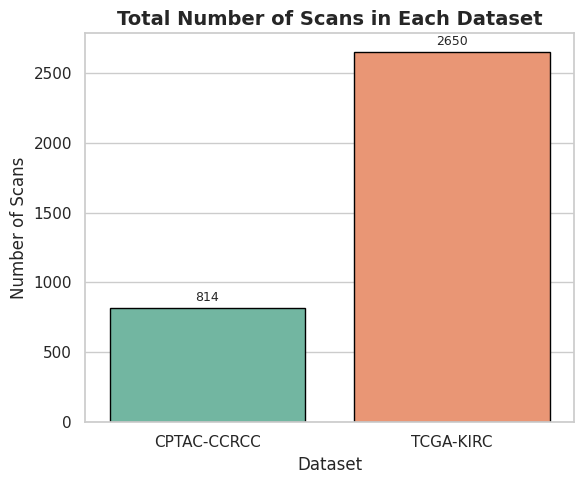

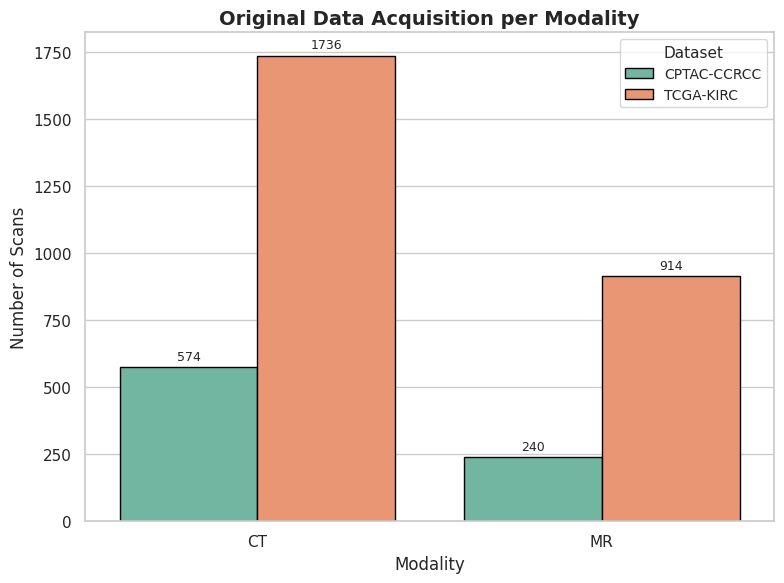

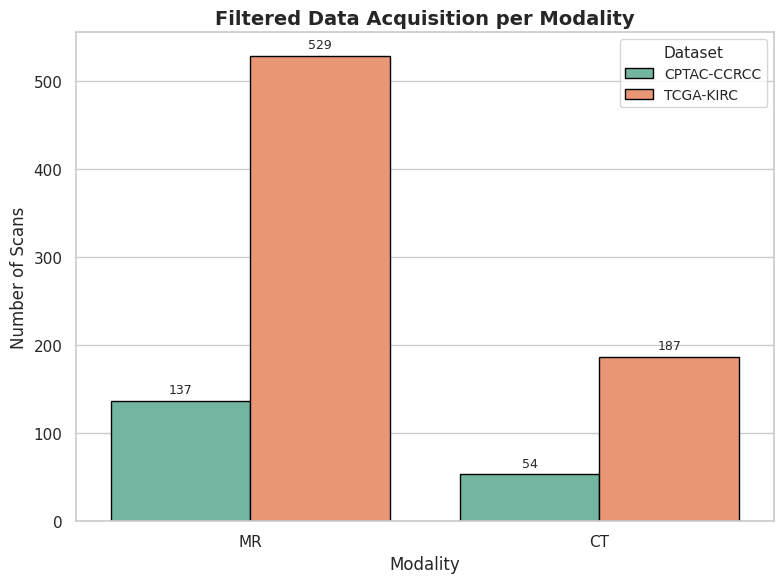

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_modality_distribution(original_cptac, original_tcga, filtered_cptac, filtered_tcga):
    sns.set(style="whitegrid")
    common_palette = sns.color_palette("Set2", n_colors=2)

    # ------------------------ Plot 0: Total Number of Scans ------------------------ #
    total_counts = pd.DataFrame({
        'Dataset': ['CPTAC-CCRCC', 'TCGA-KIRC'],
        'Total Scans': [len(original_cptac), len(original_tcga)]
    })
    
    plt.figure(figsize=(6, 5))
    ax0 = sns.barplot(
        data=total_counts,
        x='Dataset',
        y='Total Scans',
        hue='Dataset',          # Fix for the FutureWarning
        palette=common_palette,
        edgecolor='black',
        legend=False            # Hides the duplicate legend
    )
    
    for container in ax0.containers:
        ax0.bar_label(container, fmt='%d', label_type='edge', padding=3, fontsize=9)
    
    plt.title("Total Number of Scans in Each Dataset", fontsize=14, weight='bold')
    plt.xlabel("Dataset", fontsize=12)
    plt.ylabel("Number of Scans", fontsize=12)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    plt.tight_layout()
    plt.savefig("/workspace/Diploma_Project/Data_TCGA/total_scans.png", dpi=300)
    plt.show()


    # ------------------------ Plot 1: Original Scans by Modality ------------------------ #
    data_original = pd.concat([
        original_cptac['Modality'].value_counts().rename("CPTAC-CCRCC"),
        original_tcga['Modality'].value_counts().rename("TCGA-KIRC")
    ], axis=1).fillna(0).reset_index().rename(columns={'index': 'Modality'}).melt(
        id_vars='Modality', var_name='Dataset', value_name='Count'
    )

    plt.figure(figsize=(8, 6))
    ax1 = sns.barplot(data=data_original, x="Modality", y="Count", hue="Dataset",
                      palette=common_palette, edgecolor='black')

    for container in ax1.containers:
        ax1.bar_label(container, fmt='%d', label_type='edge', padding=3, fontsize=9)

    plt.title("Original Data Acquisition per Modality", fontsize=14, weight='bold')
    plt.xlabel("Modality", fontsize=12)
    plt.ylabel("Number of Scans", fontsize=12)
    plt.xticks(rotation=0, fontsize=11)
    plt.yticks(fontsize=11)
    plt.legend(title="Dataset", title_fontsize=11, fontsize=10)
    plt.tight_layout()
    plt.savefig("/workspace/Diploma_Project/Data_TCGA/original_data_acquisition.png", dpi=300)
    plt.show()

    # ------------------------ Plot 2: Filtered Scans by Modality ------------------------ #
    data_filtered = pd.concat([
        filtered_cptac['Modality'].value_counts().rename("CPTAC-CCRCC"),
        filtered_tcga['Modality'].value_counts().rename("TCGA-KIRC")
    ], axis=1).fillna(0).reset_index().rename(columns={'index': 'Modality'}).melt(
        id_vars='Modality', var_name='Dataset', value_name='Count'
    )

    plt.figure(figsize=(8, 6))
    ax2 = sns.barplot(data=data_filtered, x="Modality", y="Count", hue="Dataset",
                      palette=common_palette, edgecolor='black')

    for container in ax2.containers:
        ax2.bar_label(container, fmt='%d', label_type='edge', padding=3, fontsize=9)

    plt.title("Filtered Data Acquisition per Modality", fontsize=14, weight='bold')
    plt.xlabel("Modality", fontsize=12)
    plt.ylabel("Number of Scans", fontsize=12)
    plt.xticks(rotation=0, fontsize=11)
    plt.yticks(fontsize=11)
    plt.legend(title="Dataset", title_fontsize=11, fontsize=10)
    plt.tight_layout()
    plt.savefig("/workspace/Diploma_Project/Data_TCGA/filtered_data_acquisition.png", dpi=300)
    plt.show()

# Call the function
plot_modality_distribution(cptac_df, tcga_df, filtered_cptac, filtered_tcga)


In [109]:
import pandas as pd

def summarize_filtering_table(original_df, filtered_df, dataset_name, top_n=10):
    print(f"\n===== {dataset_name} Dataset Summary =====")
    
    original_count = len(original_df)
    filtered_count = len(filtered_df)
    pct_kept = filtered_count / original_count
    
    print(f"Original scans: {original_count}")
    print(f"Filtered scans: {filtered_count}")
    print(f"Percentage kept: {pct_kept:.1%}")
    
    # Top included (kept) scans
    top_kept = filtered_df['SeriesDescription'].value_counts().head(top_n)
    kept_table = top_kept.reset_index()
    kept_table.columns = ['Series Description (Kept)', 'Count']
    
    # Top excluded scans
    excluded = original_df[~original_df.index.isin(filtered_df.index)]
    top_excluded = excluded['SeriesDescription'].value_counts().head(top_n)
    excluded_table = top_excluded.reset_index()
    excluded_table.columns = ['Series Description (Excluded)', 'Count']
    
    # Merge into one table side-by-side for slide
    summary_table = pd.concat([kept_table, excluded_table], axis=1)
    
    print("\nTop Included and Excluded Scan Types:")
    print(summary_table.to_string(index=False))
    
    return summary_table

# Generate tables for each dataset
cptac_table = summarize_filtering_table(cptac_df, filtered_cptac, "CPTAC-CCRCC")
tcga_table = summarize_filtering_table(tcga_df, filtered_tcga, "TCGA-KIRC")



===== CPTAC-CCRCC Dataset Summary =====
Original scans: 814
Filtered scans: 191
Percentage kept: 23.5%

Top Included and Excluded Scan Types:
   Series Description (Kept)  Count Series Description (Excluded)  Count
         Topogram  0.6  T20s     13           Topogram  0.6  T20s     13
         Topogram  1.0  T20s      6                         SCOUT     12
               Axial Body CE      4                         Scout      8
T1 VIBE FS AX  BH 4 MEASURES      4        Faza tetnicza  1.5  3D      7
         Topogram  0.6  T20f      3        Jama Brzuszna  1.5  3D      7
                AX THK DELAY      2           Faza zylna  1.5  3D      7
                AX THN DELAY      2   Jama Brzuszna  5.0  miekkie      7
               AX THK PORTAL      2      Faza zylna  5.0  miekkie      7
               AX THN PORTAL      2   Faza tetnicza  5.0  miekkie      7
                   AX THK NC      2             Smart Prep Series      6

===== TCGA-KIRC Dataset Summary =====
Original scans:

In [120]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import table

def plot_summary_table(df, dataset_name, output_path):
    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 6))
    ax = plt.gca()
    ax.axis('off')

    # Remove index before plotting table
    df_no_index = df.copy()
    df_no_index.index = [''] * len(df_no_index)

    # Draw table without index
    tbl = table(ax, df_no_index, loc='center', cellLoc='center', colWidths=[0.35]*len(df.columns))
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(11)
    tbl.scale(1.2, 1.5)

    # Style table headers and rows
    for key, cell in tbl.get_celld().items():
        if key[0] == 0:  # Header row
            cell.set_text_props(weight='bold', color='black')
            cell.set_facecolor('#e1f0f8')
        else:
            cell.set_facecolor('white') if key[0] % 2 else cell.set_facecolor('#f9f9f9')

    plt.title(f"{dataset_name} - Top Included and Excluded Scan Types", fontsize=16, weight='bold', pad=20)
    plt.tight_layout()
    plt.savefig(output_path, dpi=300)
    plt.close()

# Example usage
cptac_table = summarize_filtering_table(cptac_df, filtered_cptac, "CPTAC-CCRCC")
tcga_table = summarize_filtering_table(tcga_df, filtered_tcga, "TCGA-KIRC")

plot_summary_table(cptac_table, "CPTAC-CCRCC", "cptac_table_plot.png")
plot_summary_table(tcga_table, "TCGA-KIRC", "tcga_table_plot.png")



===== CPTAC-CCRCC Dataset Summary =====
Original scans: 814
Filtered scans: 191
Percentage kept: 23.5%

Top Included and Excluded Scan Types:
   Series Description (Kept)  Count Series Description (Excluded)  Count
         Topogram  0.6  T20s     13           Topogram  0.6  T20s     13
         Topogram  1.0  T20s      6                         SCOUT     12
               Axial Body CE      4                         Scout      8
T1 VIBE FS AX  BH 4 MEASURES      4        Faza tetnicza  1.5  3D      7
         Topogram  0.6  T20f      3        Jama Brzuszna  1.5  3D      7
                AX THK DELAY      2           Faza zylna  1.5  3D      7
                AX THN DELAY      2   Jama Brzuszna  5.0  miekkie      7
               AX THK PORTAL      2      Faza zylna  5.0  miekkie      7
               AX THN PORTAL      2   Faza tetnicza  5.0  miekkie      7
                   AX THK NC      2             Smart Prep Series      6

===== TCGA-KIRC Dataset Summary =====
Original scans:

## ✅ Step 5: Resize & Extract Features with MeD3D

🎯 **Goal**:

For each CT/MRI scan:

- **Resize** to `448×448×56`
- **Normalize** (as in MeD3D)
- **Pass through** 3D ResNet18 (MeD3D)
- **Save** the resulting **512-dim feature vector**


### 🧠 MeD3D Recap

- Paper uses [MeD3D](https://github.com/BTflow/MeD3D) — a **3D ResNet18** pretrained on 23 medical datasets.
- **Input**: 3D volumes resized to `448×448×56`
- **Output**: A **512-dim feature vector** from the last conv layer + GAP (Global Average Pooling)


### 📦 Implementation Plan

---

#### 1. Load and Preprocess DICOM

- Load `.dcm` → numpy 3D volume  
- Resize to `448×448×56` (using `scipy.ndimage.zoom` or `torch.nn.functional.interpolate`)  
- Normalize intensities  

---

#### 2. Run through MeD3D

- Load pretrained weights (can help you with that)  
- Get feature vector  

---

#### 3. Save Output

- Save feature vector as `.npy`:
- `features/<PatientID>/<SeriesUID>.npy`

  




In [30]:
# !pip install --break-system-packages pydicom
# !pip install --break-system-packages gdown

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 9.2 MB/s eta 0:00:00a 0:00:01
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


## ✅ What We'll Do Now

🎯 **Goal**:  
Build a custom **MedicalNet-based feature extractor** that:

1. Loads **DICOM volumes** (CT/MRI)  
2. Resizes them to `448×448×56`  
3. Normalizes intensities (as in MedicalNet)  
4. Extracts a **512-dim feature vector** using pretrained **3D-ResNet18**  
5. Saves `.npy` per scan


### 📦 Preparation

## ✅ Requirements

Please make sure you have:

```bash
pip install torch torchvision tqdm scikit-image pydicom nibabel SimpleITK
```
`features/<PatientID>/<SeriesUID>.npy`

And download pretrained weights from MedicalNet:

- Choose: resnet_18_23dataset.pth
- Link: Google Drive (MedicalNet Pretrained)
- Save it to: `/workspace/Diploma_Project/Data_TCGA/MedicalNet/pretrain`








In [2]:
import os
import gdown
import zipfile
from pathlib import Path

def download_and_extract_medicalnet():
    save_dir = "/workspace/Diploma_Project/Data_TCGA/MedicalNet"
    os.makedirs(save_dir, exist_ok=True)
    
    # Download the zip archive
    zip_path = os.path.join(save_dir, "medical_net.zip")
    print("Downloading MedicalNet archive...")
    gdown.download(
        "https://drive.google.com/uc?id=13tnSvXY7oDIEloNFiGTsjUIYfS3g3BfG",
        zip_path,
        quiet=False
    )
    
    # Extract specific model
    pretrain_dir = os.path.join(save_dir, "pretrain")
    os.makedirs(pretrain_dir, exist_ok=True)
    
    print("Extracting resnet_18_23dataset.pth...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        # Extract only the ResNet-18 weights
        for file in zip_ref.namelist():
            if "resnet_18" in file and file.endswith(".pth"):
                zip_ref.extract(file, pretrain_dir)
                # Rename to standard filename
                extracted_path = os.path.join(pretrain_dir, file)
                final_path = os.path.join(pretrain_dir, "resnet_18_23dataset.pth")
                os.rename(extracted_path, final_path)
                break
    
    # Verify
    model_path = os.path.join(pretrain_dir, "resnet_18_23dataset.pth")
    if os.path.exists(model_path):
        size = os.path.getsize(model_path) / (1024*1024)
        print(f"✓ Model ready at {model_path} ({size:.1f} MB)")
        return model_path
    else:
        raise FileNotFoundError("Failed to extract model weights")

if __name__ == "__main__":
    model_path = download_and_extract_medicalnet()

Downloading...
From (original): https://drive.google.com/uc?id=13tnSvXY7oDIEloNFiGTsjUIYfS3g3BfG
From (redirected): https://drive.google.com/uc?id=13tnSvXY7oDIEloNFiGTsjUIYfS3g3BfG&confirm=t&uuid=51ae0633-d7ed-4533-a20b-d477b5bd4869
To: /workspace/Diploma_Project/Data_TCGA/MedicalNet/medical_net.zip
100%|████████████████████████████████████████████████████████████████████████████████████████| 2.80G/2.80G [00:58<00:00, 47.6MB/s]


Extracting resnet_18_23dataset.pth...
✓ Model ready at /workspace/Diploma_Project/Data_TCGA/MedicalNet/pretrain/resnet_18_23dataset.pth (125.9 MB)


In [3]:
!pip install --break-system-packages pydicom
!pip install --break-system-packages gdown

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


### ✅ Python Script: Feature Extractor with MedicalNet
Here's a complete standalone script for feature extraction:

In [5]:
import os
import torch
import numpy as np
import pydicom
from pathlib import Path
from tqdm import tqdm
from skimage.transform import resize
from concurrent.futures import ThreadPoolExecutor

# Add MedicalNet to Python path
import sys
sys.path.append("/workspace/Diploma_Project/Data_TCGA/MedicalNet/pretrain")  # Path to cloned repository
from models.resnet import resnet18  # Import the specific model architecture

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Config ---
model_path = "/workspace/Diploma_Project/Data_TCGA/MedicalNet/pretrain/resnet_18_23dataset.pth"
data_root = Path("/workspace/Diploma_Project/Data_TCGA/processed_scans/organized_scans")
save_root = Path("/workspace/Diploma_Project/Data_TCGA/features/med3d")
save_root.mkdir(parents=True, exist_ok=True)

# --- Initialize MedicalNet Model ---
model = resnet18(
    sample_input_W=448,
    sample_input_H=448,
    sample_input_D=56,
    num_seg_classes=1,
    shortcut_type='A',
    no_cuda=False
).to(device)

# Load pretrained weights
try:
    checkpoint = torch.load(model_path, map_location=device)
    if 'state_dict' in checkpoint:
        state_dict = checkpoint['state_dict']
    else:
        state_dict = checkpoint
    
    # Remove 'module.' prefix if present (from DataParallel)
    state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}
    
    # Load weights
    model.load_state_dict(state_dict, strict=False)
    print("Successfully loaded pretrained weights")
except Exception as e:
    print(f"Error loading weights: {e}")
    print("Initializing model with random weights")

# Remove classification head and keep feature extractor
model = torch.nn.Sequential(*list(model.children())[:-1])  # Outputs 512-D
model.eval()


# [Previous imports remain the same]
from concurrent.futures import ThreadPoolExecutor

def load_dicom_volume(folder):
    slices = []
    for f in sorted(Path(folder).glob("*.dcm")):
        try:
            dcm = pydicom.dcmread(str(f))
            if hasattr(dcm, "pixel_array"):
                # Use InstanceNumber or fallback to file sort if no SliceLocation
                slice_position = getattr(dcm, "SliceLocation", None)
                if slice_position is None:
                    slice_position = getattr(dcm, "InstanceNumber", None)
                slices.append((slice_position, dcm.pixel_array.astype(np.float32)))
        except Exception as e:
            print(f"⚠️ Error loading {f.name} in {folder.name}: {str(e)}")
            continue

    # Remove any without position
    slices = [s for s in slices if s[0] is not None]

    if not slices:
        print(f"❌ No valid slices found in {folder}")
        return None
    
    # Sort and stack
    slices.sort(key=lambda x: x[0])
    return np.stack([s[1] for s in slices], axis=0)  # [D, H, W]


def process_series(series_folder, collection, patient_folder):
    """Process a single DICOM series"""
    out_path = save_root / collection / patient_folder.name / (series_folder.name + ".npy")
    if out_path.exists():
        return None
        
    vol = load_dicom_volume(series_folder)
    if vol is None:
        return f"Skipped: {series_folder.name}"
        
    try:
        vol_tensor = preprocess_volume(vol)
        with torch.no_grad():
            features = model(vol_tensor).cpu().numpy().mean(axis=(2,3,4))
        
        out_path.parent.mkdir(parents=True, exist_ok=True)
        np.save(out_path, features.squeeze(0))
        return f"Processed: {series_folder.name}"
    except Exception as e:
        return f"Failed {series_folder.name}: {str(e)}"

def extract_and_save_features():
    """Parallelized feature extraction"""
    with ThreadPoolExecutor(max_workers=4) as executor:
        for collection in ['CPTAC-KIRC', 'TCGA-KIRC']:
            futures = []
            for patient_folder in (data_root / collection).iterdir():
                if not patient_folder.is_dir():
                    continue
                for series_folder in patient_folder.iterdir():
                    futures.append(
                        executor.submit(
                            process_series,
                            series_folder,
                            collection,
                            patient_folder
                        )
                    )
            
            # Progress tracking
            for future in tqdm(futures, desc=collection):
                result = future.result()
                if result and ("Skipped" in result or "Failed" in result):
                    print(result)

extract_and_save_features()


# # --- Volume Loader ---
# def load_dicom_volume(folder):
#     slices = []
#     for f in sorted(Path(folder).glob("*.dcm")):
#         try:
#             dcm = pydicom.dcmread(str(f))
#             if hasattr(dcm, "SliceLocation"):
#                 slices.append((dcm.SliceLocation, dcm.pixel_array.astype(np.float32)))
#         except Exception as e:
#             print(f"Error loading {f}: {str(e)}")
#             continue
#     if not slices:
#         return None
#     slices.sort(key=lambda x: x[0])
#     return np.stack([s[1] for s in slices], axis=0)  # [D, H, W]

# # --- MedicalNet Preprocessing ---
# def preprocess_volume(volume, target_shape=(56, 448, 448)):
#     # 1. HU Clipping (CT-specific)
#     volume = np.clip(volume, -1024, 1024)
    
#     # 2. MedicalNet Normalization (mean=-158.58, std=324.70)
#     volume = (volume + 158.58) / 324.70
    
#     # 3. Resize to model input shape
#     resized = resize(volume, output_shape=target_shape, preserve_range=True)
    
#     # 4. Add batch and channel dims
#     return torch.tensor(resized, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)  # [1, 1, D, H, W]

# # --- Feature Extraction ---
# def extract_and_save_features():
#     for collection in ['CPTAC-KIRC', 'TCGA-KIRC']:
#         collection_dir = data_root / collection
#         if not collection_dir.exists():
#             continue
            
#         for patient_folder in tqdm(list(collection_dir.iterdir()), desc=collection):
#             if not patient_folder.is_dir():
#                 continue
                
#             for series_folder in patient_folder.iterdir():
#                 out_path = save_root / collection / patient_folder.name / (series_folder.name + ".npy")
#                 if out_path.exists():
#                     continue
                    
#                 vol = load_dicom_volume(series_folder)
#                 if vol is None:
#                     print(f"Skipped (no valid DICOMs): {series_folder}")
#                     continue
                    
#                 # Preprocess and extract features
#                 vol_tensor = preprocess_volume(vol)
#                 with torch.no_grad():
#                     features = model(vol_tensor).cpu().numpy()  # [1, 512, 7, 56, 56]
#                     # Add standardization:
#                     features = (features - features.mean()) / (features.std() + 1e-8)
#                     features = features.mean(axis=(2, 3, 4))  # Global avg pooling [1, 512]
                
#                 # Save features
#                 out_path.parent.mkdir(parents=True, exist_ok=True)
#                 np.save(out_path, features.squeeze(0))  # Save as [512]

# # Run feature extraction
# extract_and_save_features()

ModuleNotFoundError: No module named 'models'